# Relational Databases in Practice

## From Theory to Tables

The previous chapter introduced relational theory's mathematical foundations: relations as sets of tuples, functional dependencies, and the formal operations of relational algebra. While this mathematical rigor provides the theoretical foundation for database systems, most practitioners don't design databases by analyzing functional dependencies or proving normal form properties.

Instead, they use the **Entity-Relationship Model (ERM)**, a practical design methodology that maps domain concepts—the entities and relationships in your problem space—directly to database structures. This chapter shows how ERM works in practice, demonstrates common database operations, and reveals the limitations that motivate DataJoint's workflow-centric approach.

We'll work through a concrete example: designing a database for a research lab that conducts experiments, collects measurements, and analyzes results. This scenario will illustrate both the power and the limitations of traditional relational databases for scientific workflows.


## A Working Example: Research Lab Database

### The Domain

Consider a neuroscience research lab that studies visual perception. The lab has several researchers who design and conduct experiments. Each experiment involves presenting visual stimuli to animal subjects and recording neural activity. The raw recordings are then analyzed to extract useful information about how neurons respond to different stimuli.

This is a typical scientific workflow with several distinct stages:
1. **Study Design**: Researchers plan experiments
2. **Data Acquisition**: Experiments generate raw recordings
3. **Data Processing**: Raw data is analyzed to extract results
4. **Interpretation**: Results are interpreted in the context of research questions

Let's design a database to support this workflow.


### Identifying Entities

The first step in ERM is identifying the **entities**—the distinct "things" in your domain that have independent existence and need to be tracked.

In our research lab, we can identify several entities:

- **Researcher**: People conducting the research
- **AnimalSubject**: The experimental subjects
- **Experiment**: A planned experimental session
- **Recording**: Raw data collected during an experiment
- **NeuralUnit**: Individual neurons identified in recordings

### Identifying Relationships

Entities don't exist in isolation—they're connected through **relationships** that capture how they interact:

- A **Researcher** *conducts* an **Experiment** (one-to-many: one researcher can conduct multiple experiments)
- An **AnimalSubject** *participates in* an **Experiment** (one-to-many: one subject can participate in multiple experiments)
- An **Experiment** *produces* **Recordings** (one-to-many: one experiment can generate multiple recordings)
- A **Recording** *contains* **NeuralUnits** (one-to-many: one recording can contain many identified neurons)


### Drawing the ER Diagram

We can visualize this structure using Crow's Foot notation:

```mermaid
erDiagram
    RESEARCHER ||--o{ EXPERIMENT : conducts
    ANIMAL_SUBJECT ||--o{ EXPERIMENT : "participates-in"
    EXPERIMENT ||--o{ RECORDING : produces
    RECORDING ||--o{ NEURAL_UNIT : contains
    
    RESEARCHER {
        int researcher_id PK
        string researcher_name
        string email
        string lab_role
    }
    
    ANIMAL_SUBJECT {
        int subject_id PK
        string species
        date date_of_birth
        string sex
    }
    
    EXPERIMENT {
        int experiment_id PK
        int researcher_id FK
        int subject_id FK
        date experiment_date
        string description
        string protocol
    }
    
    RECORDING {
        int experiment_id PK, FK
        int recording_id PK
        datetime recording_time
        string file_path
        string recording_quality
    }
    
    NEURAL_UNIT {
        int experiment_id PK, FK
        int recording_id PK, FK        
        int unit_id PK
        float spike_rate
        float receptive_field_size
    }
```

The diagram shows:
- **Entities** as rectangles containing their attributes
- **Primary keys (PK)**: Unique identifiers for each entity
- **Foreign keys (FK)**: References to related entities
- **Relationships** as lines with symbols indicating cardinality:
  - `||` means "exactly one"
  - `o{` means "zero or many"


### Translating to SQL Tables

The ER diagram translates almost directly to SQL table definitions:


```sql

-- Create all tables for the research lab database

CREATE TABLE Researcher (
    researcher_id INT,
    name VARCHAR(100) NOT NULL,
    email VARCHAR(100) UNIQUE,
    lab_role VARCHAR(50),
    PRIMARY KEY(researcher_id)
);

CREATE TABLE AnimalSubject (
    subject_id INT PRIMARY KEY,
    species VARCHAR(50) NOT NULL,
    date_of_birth DATE,
    sex ENUM('M', 'F', 'Unknown')
);

CREATE TABLE Experiment (
    experiment_id INT,
    researcher_id INT NOT NULL,
    subject_id INT NOT NULL,
    experiment_date DATE NOT NULL,
    description TEXT,
    protocol VARCHAR(100),
    PRIMARY KEY (experiment_id),
    FOREIGN KEY (researcher_id) REFERENCES Researcher(researcher_id),
    FOREIGN KEY (subject_id) REFERENCES AnimalSubject(subject_id)
);

CREATE TABLE Recording (
    experiment_id INT NOT NULL,
    recording_id INT NOT NULL,
    recording_time DATETIME NOT NULL,
    file_path VARCHAR(255) NOT NULL,
    recording_quality ENUM('excellent', 'good', 'fair', 'poor'),
    PRIMARY KEY (experiment_id, recording_id),
    FOREIGN KEY (experiment_id) REFERENCES Experiment(experiment_id)
);

CREATE TABLE NeuralUnit (
    experiment_id INT NOT NULL,
    recording_id INT NOT NULL,
    unit_id INT NOT NULL,
    spike_rate FLOAT NOT NULL,
    receptive_field_size FLOAT NOT NULL,
    PRIMARY KEY (experiment_id, recording_id, unit_id),
    FOREIGN KEY (experiment_id, recording_id) REFERENCES Recording(experiment_id, recording_id)
);
```

Note the key features:
- **PRIMARY KEY**: Ensures each row has a unique identifier
- **FOREIGN KEY**: Enforces referential integrity—you can't reference a non-existent entity
- **NOT NULL**: Requires certain attributes to have values
- **Data types**: Constrain what values can be stored (INT, VARCHAR, DATE, etc.)

### Populating with Sample Data

Let's add some sample data to see the database in action:

```sql
-- Add researchers
INSERT INTO Researcher (researcher_id, name, email, lab_role) VALUES
    (1, 'Dr. Sarah Chen', 'schen@university.edu', 'Principal Investigator'),
    (2, 'Alex Martinez', 'amartinez@university.edu', 'Postdoc'),
    (3, 'Jamie Park', 'jpark@university.edu', 'Graduate Student');

-- Add animal subjects
INSERT INTO AnimalSubject (subject_id, species, date_of_birth, sex) VALUES
    (1, 'Mouse', '2024-01-15', 'M'),
    (2, 'Mouse', '2024-01-20', 'F'),
    (3, 'Mouse', '2024-02-03', 'M');

-- Add an experiment
INSERT INTO Experiment (experiment_id, researcher_id, subject_id, experiment_date, description, protocol) VALUES
    (1, 2, 1, '2024-08-15', 'Visual cortex recording during grating stimuli', 'Protocol-V1-001');

-- Add recordings from that experiment
INSERT INTO Recording (experiment_id, recording_id, recording_time, file_path, recording_quality) VALUES
    (1, 1, '2024-08-15 10:30:00', '/data/2024/08/15/rec001.dat', 'excellent'),
    (1, 2, '2024-08-15 11:45:00', '/data/2024/08/15/rec002.dat', 'good');

-- Add neural units identified in first recording
INSERT INTO NeuralUnit (experiment_id, recording_id, unit_id, spike_rate, receptive_field_size) VALUES
    (1, 1, 1, 15.3, 2.5),
    (1, 1, 2, 8.7, 3.1),
    (1, 1, 3, 22.4, 1.8);
```

### Inserting Data: Adding New Records

Adding data follows a hierarchical pattern dictated by foreign keys:


```sql
-- Must add researcher before experiments they conduct
INSERT INTO Researcher (researcher_id, name, email, lab_role) 
VALUES (4, 'Dr. Maria Rodriguez', 'mrodriguez@university.edu', 'Assistant Professor');

-- Must add experiment before its recordings
INSERT INTO Experiment (experiment_id, researcher_id, subject_id, experiment_date, description, protocol)
VALUES (2, 4, 2, '2024-09-20', 'Orientation selectivity experiment', 'Protocol-V1-002');

-- Can only add recording after experiment exists
INSERT INTO Recording (experiment_id, recording_id, recording_time, file_path, recording_quality)
VALUES (2, 1, '2024-09-20 14:00:00', '/data/2024/09/20/rec001.dat', 'excellent');
```

The foreign key constraints enforce this order—you can't reference entities that don't exist yet.

## The Same Schema, A Different Perspective

Let's now build the exact same database using DataJoint. Notice that **the resulting database schema structure is identical**—we have the same tables, the same relationships, the same constraints. But DataJoint views this schema through a fundamentally different lens: **as a workflow specification, not just a data structure**.

**Traditional SQL View**: The schema describes **entities and their relationships**—a static structure for storing data.

**DataJoint View**: The schema describes **a workflow**—a directed sequence of steps showing how data flows from inputs to outputs.

[2025-10-31 19:50:04,787][INFO]: DataJoint 0.14.6 connected to dev@db:3306


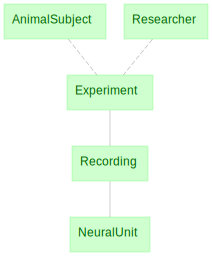

In [2]:
import datajoint as dj

schema = dj.Schema('research_lab')

@schema
class Researcher(dj.Manual):
    definition = """
    researcher_id: int
    ---
    researcher_name: varchar(100)
    email: varchar(100)
    lab_role: varchar(50)
    UNIQUE INDEX(email)
    """

@schema
class AnimalSubject(dj.Manual):
    definition = """
    subject_id: int
    ---
    species: varchar(50)
    date_of_birth: date
    sex: enum('M', 'F', 'Unknown')
    """

@schema
class Experiment(dj.Manual):
    definition = """
    experiment_id: int
    ---
    -> Researcher
    -> AnimalSubject
    experiment_date: date
    description: varchar(255)
    protocol: varchar(100)
    """

@schema
class Recording(dj.Manual):
    definition = """
    -> Experiment
    recording_id: int
    ---
    recording_time: datetime
    file_path: varchar(255)
    recording_quality: enum('excellent', 'good', 'fair', 'poor')
    """

@schema
class NeuralUnit(dj.Manual):
    definition = """
    -> Recording
    unit_id: int
    ---
    spike_rate: float
    receptive_field_size: float
    """

dj.Diagram(schema)


### Schema as Workflow: Understanding the Difference

Look at the DataJoint diagram above. Notice how it shows a **workflow sequence** (read top to bottom):

1. **Researcher** and **AnimalSubject** (Manual tables) - *Inputs* to the workflow
2. **Experiment** - A workflow step that *combines* these inputs  
3. **Recording** - The next step, *produced from* the experiment
4. **NeuralUnit** - The final step, *derived from* the recording

The arrows don't just mean "this references that" (foreign keys). They mean **"this workflow step depends on that workflow step"**.

This workflow perspective shapes everything:
- **Table types indicate roles**: Manual tables are inputs; Computed tables are automatic processing steps
- **The diagram shows operational sequence**: Top-to-bottom indicates the order of operations
- **The schema enforces workflow validity**: You can't have downstream results without upstream inputs

Let's populate this workflow with the same data:


In [3]:
# Add researchers
Researcher.insert([
    (1, 'Dr. Sarah Chen', 'schen@university.edu', 'Principal Investigator'),
    (2, 'Alex Martinez', 'amartinez@university.edu', 'Postdoc'),
    (3, 'Jamie Park', 'jpark@university.edu', 'Graduate Student'),
])

# Add animal subjects
AnimalSubject.insert([
    dict(subject_id=1, species='Mouse', date_of_birth='2024-01-15', sex='M'),
    dict(subject_id=2, species='Mouse', date_of_birth='2024-01-20', sex='F'),
    dict(subject_id=3, species='Mouse', date_of_birth='2024-02-03', sex='M'),
])

# Add an experiment
Experiment.insert1(dict(
    experiment_id=1,
    researcher_id=2,
    subject_id=1,
    experiment_date='2024-08-15',
    description='Visual cortex recording during grating stimuli',
    protocol='Protocol-V1-001'
))

# Add recordings from that experiment
Recording.insert([
    dict(
        experiment_id=1,
        recording_id=1,
        recording_time='2024-08-15 10:30:00',
        file_path='/data/2024/08/15/rec001.dat',
        recording_quality='excellent'
    ),
    dict(
        experiment_id=1,
        recording_id=2,
        recording_time='2024-08-15 11:45:00',
        file_path='/data/2024/08/15/rec002.dat',
        recording_quality='good'
    ),
])

# Add neural units identified in first recording
NeuralUnit.insert([
    dict(experiment_id=1, recording_id=1, unit_id=1, spike_rate=15.3, receptive_field_size=2.5),
    dict(experiment_id=1, recording_id=1, unit_id=2, spike_rate=8.7, receptive_field_size=3.1),
    dict(experiment_id=1, recording_id=1, unit_id=3, spike_rate=22.4, receptive_field_size=1.8),
])


In [4]:
### Adding new data must follow the workflow order

Researcher.insert1((4, 'Dr. Maria Rodriguez', 'mrodriguez@university.edu', 'Assistant Professor'));

# Add experiment before adding its recordings
Experiment.insert1(dict(
    experiment_id=2,
    researcher_id=4,
    subject_id=2,
    experiment_date='2024-09-20',
    description='Orientation selectivity experiment',
    protocol='Protocol-V1-002'
))

# Can only add recording after experiment exists
Recording.insert1(dict(
    experiment_id=2,
    recording_id=1,
    recording_time='2024-09-20 14:00:00',
    file_path='/data/2024/09/20/rec001.dat',
    recording_quality='excellent'
))


The syntax differences (Python dictionaries, `insert()` methods) are minor. The **fundamental difference** is conceptual:

**SQL sees**: Five tables with foreign key relationships

**DataJoint sees**: A four-step workflow:
1. Start with Researcher and AnimalSubject (inputs)
2. Create Experiment (combines inputs)
3. Add Recording (produces data from experiment)
4. Identify NeuralUnits (analyzes recording)

This workflow view will become crucial when we introduce Computed tables—then DataJoint will automatically execute each workflow step when its inputs are ready.


## Common Database Operations

We'll briefly demonstrate SQL operations to contrast them with DataJoint. The operations work the same—the difference is in how we *conceive* of the database.

All database queries are built from four fundamental relational operations:

1. **Restriction** (`WHERE` in SQL, `&` in DataJoint): Filter rows based on conditions
   - "Get only graduate students" → `WHERE lab_role = 'Graduate Student'` or `& {'lab_role': 'Graduate Student'}`

2. **Projection** (`SELECT columns` in SQL, `.proj()` in DataJoint): Choose which columns to return
   - "Get only name and email" → `SELECT name, email` or `.proj('name', 'email')`

3. **Join** (`JOIN` in SQL, `*` in DataJoint): Combine data from multiple related tables
   - "Get experiments with researcher names" → `Experiment JOIN Researcher` or `Experiment * Researcher`

4. **Aggregation** (`GROUP BY` in SQL, `.aggr()` in DataJoint): Compute summary statistics across groups
   - "Count neural units per recording" → `COUNT(*) GROUP BY` or `.aggr(..., n='count(*)')`

These operations work identically in SQL and DataJoint—only the syntax differs. Let's see them in action:


**Restriction** (`WHERE` clause) filters rows based on conditions. **Projection** (column selection) chooses which attributes to return. Most queries use both operations together:


### Example Queries: Restriction and Projection

**Restriction** filters rows; **Projection** selects columns. Most queries use both:

In [5]:
# Get all researchers
Researcher()

researcher_id,researcher_name,email,lab_role
1,Dr. Sarah Chen,schen@university.edu,Principal Investigator
2,Alex Martinez,amartinez@university.edu,Postdoc
3,Jamie Park,jpark@university.edu,Graduate Student
4,Dr. Maria Rodriguez,mrodriguez@university.edu,Assistant Professor


```sql
--SQL Equivalent: 
SELECT * FROM Researcher
```

In [6]:
# Get specific entries and attributes for researchers
(Researcher & {'lab_role': 'Graduate Student'}).proj('researcher_name', 'email')

researcher_id,researcher_name,email
3,Jamie Park,jpark@university.edu


```sql
-- SQL Equivalent: 
SELECT researcher_name, email
FROM Researcher
WHERE lab_role = 'Graduate Student'
```

### Example Queries: Join Operations

**Join** combines related data from multiple tables. The foreign key relationships tell us which tables can be meaningfully joined:


In [7]:
# Which researcher conducted each experiment?
(Experiment * Researcher).proj('experiment_date', 'researcher_name')

experiment_id,researcher_id,experiment_date,researcher_name
1,2,2024-08-15,Alex Martinez
2,4,2024-09-20,Dr. Maria Rodriguez


```sql
-- SQL Equivalent:
SELECT experiment_id, experiment_date, researcher_name 
   FROM Experiment JOIN Researcher USING (researcher_id)
```

These joins follow the foreign key relationships defined in our schema, ensuring we only combine data that's meaningfully related. Notice how:
- **Inner joins** only return rows where matches exist in both tables
- **Multiple joins** can chain through relationships (Researcher → Experiment → Recording)
- The **join condition** comes from the foreign key (e.g., `researcher_id`)


In [8]:
# Full experiment details including subject**
(Experiment * Researcher * AnimalSubject).proj(
    'experiment_date', 'researcher_name', 'species', 'sex', 'description')

experiment_id,researcher_id,subject_id,experiment_date,description,researcher_name,species,sex
1,2,1,2024-08-15,Visual cortex recording during grating stimuli,Alex Martinez,Mouse,M
2,4,2,2024-09-20,Orientation selectivity experiment,Dr. Maria Rodriguez,Mouse,F


```sql
-- SQL Equivalent:
SELECT experiment_id, experiment_date, researcher_name, species, sex, description
FROM Experiment JOIN Researcher USING(researcher_id) JOIN AnimalSubject (subject_id)
```

### Example Queries: Aggregation

**Aggregation** computes summary statistics across groups of rows:


In [9]:
# Count neural units per recording
Recording.aggr(NeuralUnit, unit_count='count(*)')

experiment_id,recording_id,unit_count calculated attribute
1,1,3


```sql
-- SQL Equivalent:
SELECT experiment_id, recording_id, COUNT(*) as unit_count 
FROM NeuralUnit 
GROUP BY experiment_id, recording_id
```

In [10]:
# Get average spike rate across all recordings
dj.U().aggr(NeuralUnit, avg_spike_rate='avg(spike_rate)', std_dev='std(spike_rate)' )

avg_spike_rate calculated attribute,std_dev calculated attribute
15.466666539510092,5.594242990034591


```sql
-- SQL equivalent: 
SELECT AVG(spike_rate), STD(spike_rate) FROM NeuralUnit
```

In [11]:
# Count recordings per researcher
Researcher.aggr(Experiment * Recording, num_recordings='count(*)')


researcher_id,num_recordings calculated attribute
2,2
4,1


```sql
-- SQL Equivalent:
SELECT researcher_id, researcher_name, COUNT(*) as num_recordings
FROM Researcher
JOIN Experiment USING (researcher_id)
JOIN Recording USING (experiment_id)
GROUP BY researcher_id
```

**Aggregation** computes summary statistics (counts, averages, sums) across groups:
- `COUNT(*)` counts rows
- `AVG(column)` computes the average
- `GROUP BY` defines the groups
- Results have one row per group

Aggregation is essential for summarizing data: how many units per recording? What's the average spike rate? Which researcher has the most recordings?


Notice how the same four fundamental operations work in DataJoint:

1. **Restriction** (`&` operator): Filters rows based on conditions
   - `Researcher & {'lab_role': 'Graduate Student'}` selects only graduate students

2. **Projection** (`.proj()` method): Selects which columns to return or defines new columns
   - `.proj('researcher_name', 'email')` returns only those columns

3. **Join** (`*` operator): Combines related tables
   - `Experiment * Researcher` joins experiments with their researchers

4. **Aggregation** (`.aggr()` method): Computes summary statistics
   - `.aggr(NeuralUnit, n='count(*)')` counts units per group

The syntax differs (`*` instead of `JOIN`, `&` instead of `WHERE`), but the **conceptual operations are identical**. What matters is that **the same relational operations work**, whether you're viewing the schema as a static structure (SQL) or as a workflow (DataJoint).

However, when we introduce **Computed tables** in the next chapters, the workflow view becomes essential. Those tables will automatically execute when their inputs are ready, something SQL cannot express.

### Deleting Data: Removing Records

In [12]:
# delete a specific recording and all its dependent neural units (below in the workflow)
(Recording & {'experiment_id': 1, 'recording_id': 1}).delete()

[2025-10-31 19:50:05,003][INFO]: Deleting 3 rows from `research_lab`.`neural_unit`
[2025-10-31 19:50:05,008][INFO]: Deleting 1 rows from `research_lab`.`recording`
[2025-10-31 19:50:08,300][WARNING]: Delete cancelled


1

```sql
-- Delete a recording (cascade to NeuralUnits)
DELETE FROM NeuralUnits WHERE experiment_id = 1 AND recording_id = 1;
DELETE FROM Recording WHERE experiment_id = 1 AND recording_id = 1;
```

## The Path Forward: Databases as Workflows

**DataJoint extends relational theory by viewing the schema as a workflow specification.** It preserves all the benefits of relational databases—mathematical rigor, declarative queries, data integrity—while adding workflow semantics that make the database **workflow-aware**.

**Key Insight**: The database schema structure can be identical whether using SQL or DataJoint, although DataJoint imposes some conventions. What's different is the **conceptual view**: SQL sees static entities and relationships; DataJoint sees an executable workflow, where some steps are manual and others are automatic. This workflow view enables automatic execution, provenance tracking, and computational validity—features essential for scientific computing.

The next chapter introduces DataJoint's Relational Workflow Model in detail, showing how Computed tables turn your schema into an executable pipeline specification.
